# Red Neuronal
En este primer ejemplo, crearemos una red neuronal "a mano" sin utilizar ningún framework ni librería. Veremos la complejidad sin ayuda

In [1]:
import numpy as np
import matplotlib.pyplot as plt
# Used to create circular dataset
from sklearn.datasets import make_circles
# Used to stop time in last append
import time
# Used to clear output in last append
from IPython.display import clear_output

---
## Funciones de Activación y Coste

La primera función de activación, no nos sirve ya que es lineal. Utilizaremos sigmoides, ReLu o Hipertangente parabólica. Por último, tenemos la función de coste para ver cómo de bien funciona nuestra red neuronal. Esta última, calculará el error entre el valor esperado y el valor predicho por la red neuronal. La segunda función declarada es la derivada de cada una de las funciones de activación (f_d)

In [3]:
# *****************
# Escalonada (inutil para el entrenamiento)
# *****************
def act_f_threshold(sum):
    sum[sum < 0] = 0
    sum[sum > 0] = 1
    return sum

# *****************
#     Sigmoide
# *****************
def act_f_sigmoid(sum):
    return 1 / (1 + np.e ** (-sum))
def act_f_d_sigmoid(sum):
    return act_f_sigmoid(sum) * (1 - act_f_sigmoid(sum))

sigmoids = (act_f_sigmoid, act_f_d_sigmoid)

# *****************
# Tangente Hiperbolica
# *****************
def act_f_hyp_tan(sum):
    return (np.e ** sum - np.e ** (-sum)) / (np.e ** sum + np.e ** (-sum))
def act_f_d_hyp_tan(sum):
    return (2 / (np.e ** sum + np.e ** (-sum))) ** 2

hyp_tans = (act_f_hyp_tan, act_f_d_hyp_tan)

# *****************
#       ReLU
# *****************
def act_f_relu(sum):
    return np.maximum(0,sum)
def act_f_d_relu(sum):
    sum[sum < 0] = 0
    return sum

relus = (act_f_relu, act_f_d_relu)

# *****************
#  Función de coste
# *****************
def cost_f(a, Y):
    return np.mean((a - Y) ** 2)
def cost_f_d(a, Y):
    return a - Y

costs = (cost_f, cost_f_d)

## Capa Neuronal

Con esta clase, definimos las neuronas que hay en una capa así como las conexiones y la función de activación. La función calc se encarga de calcular la multiplicación matricial de los predictores por los pesos y de aplicarle la función de activación que queramos.

In [4]:
class neural_layer:
    def __init__(self, n_conn, n_neur, act_f):
        self.act_f = act_f
        self.b = np.random.rand(1, n_neur)      * 2 - 1
        self.W = np.random.rand(n_conn, n_neur) * 2 - 1

    def calc(self, X):
        z = X @ self.W + self.b
        a = self.act_f[0](z)
        return (z,a)

---
## Red Neuronal

In [5]:
class neural_network:
    def __init__(self, first_input_size, neurons_per_layer, act_f_per_layer):
        self.layers = [neural_layer(first_input_size, neurons_per_layer[0], act_f_per_layer[0])]
        for l in range(1, len(neurons_per_layer)):
            self.layers.append(neural_layer(neurons_per_layer[l-1], neurons_per_layer[l], act_f_per_layer[l]))

    def test(self, X):
        a = self.layers[0].calc(X)[1]
        for l in range(1, len(self.layers)):
            a = self.layers[l].calc(a)[1]
        return a

    # Con el entrenamiento, vamos a minimizar el error de los valores de los pesos y de bías hasta que el algoritmo
    # encuentre un valor óptimo
    def train(self, X, Y, cost_f_d, lr):
        outputs = [(None, X)]

        # Forward pass
        outputs.append(self.layers[0].calc(X))
        for l in range(1, len(self.layers)):
            outputs.append(self.layers[l].calc(outputs[-1][1]))
        
        # Backward pass
        for l in range(len(self.layers) - 1, -1, -1):
            z = outputs[l+1][0]
            a = outputs[l+1][1]
            
            if l == len(self.layers) - 1:
                delta = cost_f_d(a, Y) * self.layers[l].act_f[1](z)
            else:
                delta = delta @ old_w.T * self.layers[l].act_f[1](z)
            
            # Temporarily save
            old_w = self.layers[l].W
            
            # Gradient descent. Utilizado para minimizar el error de nuestra función de coste
            # lr. El “learning rate” o “ratio de aprendizaje” nos dirá en qué proporción nos movemos en la dirección indicada. 
            # Este será un parámetro para el entrenamiento de nuestra red.

            self.layers[l].b = self.layers[l].b - np.mean(delta) * lr
            self.layers[l].W = self.layers[l].W - outputs[l][1].T @ delta * lr
        
        return outputs[-1][1]

---
# Pruebas

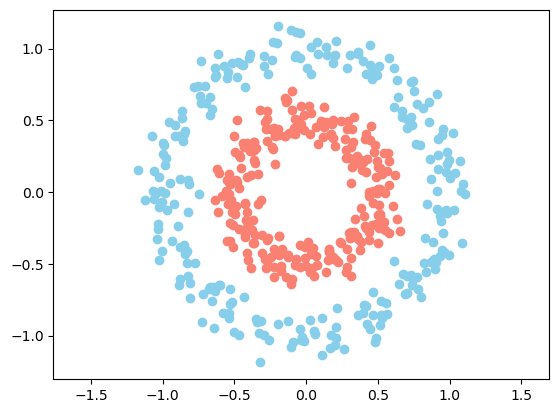

In [13]:
# Data definition
n = 500
X, Y = make_circles(n_samples=n, factor=0.5, noise=0.08)

plt.scatter(X[Y == 0, 0], X[Y == 0, 1], c="skyblue")
plt.scatter(X[Y == 1, 0], X[Y == 1, 1], c="salmon")
plt.axis("equal")
plt.show()

Y = Y[:, np.newaxis]

# np.savetxt("inputs.csv", X, delimiter=",")
# np.savetxt("outputs.csv", Y, delimiter=",")

In [8]:
# Display function
def show_training(nn, X, Y, costs, lr, iterations):
    loss = []

    for i in range(iterations):
        # Train neural network
        results = nn.train(X, Y, costs[1], lr)

        # Every 50 iterations, we check if network is learning showing the graphics
        if i % 50 == 0:
            # Save costs returns
            loss.append(costs[0](results, Y))

            # Show how our network is predicting
            res = 50
            _x0 = np.linspace(-1.5, 1.5, res)
            _x1 = np.linspace(-1.5, 1.5, res)
            _Y  = np.zeros((res, res))
            for i0, x0 in enumerate(_x0):
                for i1, x1 in enumerate(_x1):
                    _Y[i0, i1] = nn.test(np.array([[x0, x1]]))[0][0]
            
            plt.pcolormesh(_x0, _x1, _Y, cmap="coolwarm")
            plt.axis("equal")

            plt.scatter(X[Y[:,0] == 0, 0], X[Y[:,0] == 0, 1], c="skyblue")
            plt.scatter(X[Y[:,0] == 1, 0], X[Y[:,0] == 1, 1], c="salmon")

            clear_output(wait=True)
            plt.show()
            plt.plot(range(len(loss)), loss)
            plt.show()
            time.sleep(0.25)

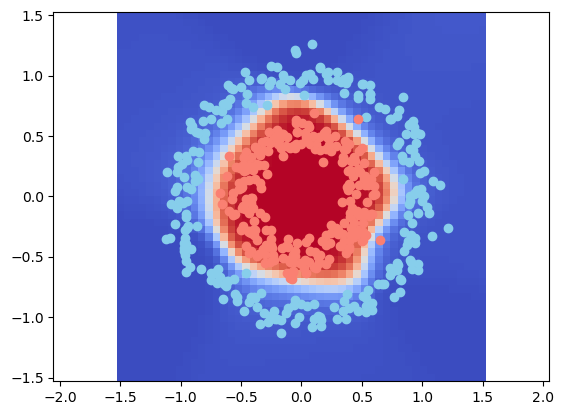

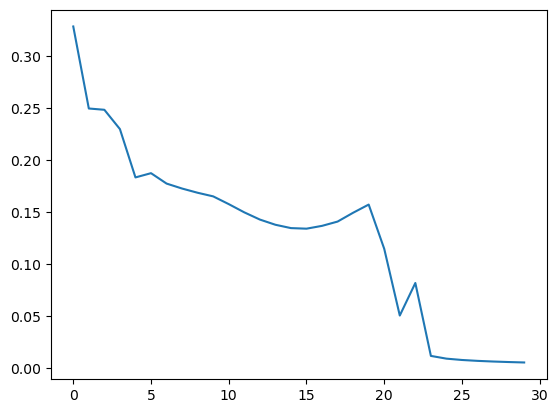

In [11]:
# Neural network definition
first_input_size = 2
neurons_per_layer = [8,4,1]

# Activations functions
#   sigmoids
#   hyp_tans
#   relus
act_f_per_layer = [sigmoids, sigmoids, sigmoids]

# Neural network creation
nn = neural_network(first_input_size, neurons_per_layer, act_f_per_layer)

# Training params
lr = 0.05
iterations = 1500

show_training(nn, X, Y, costs, lr, iterations)

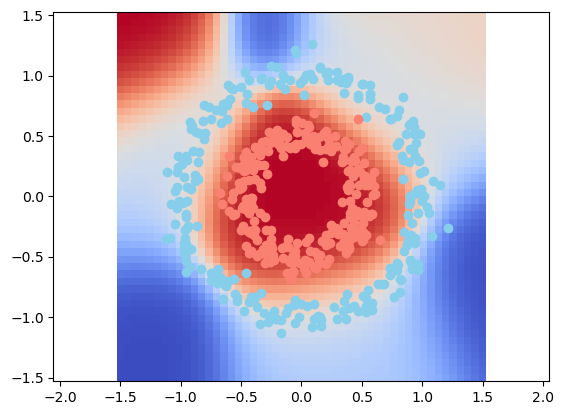

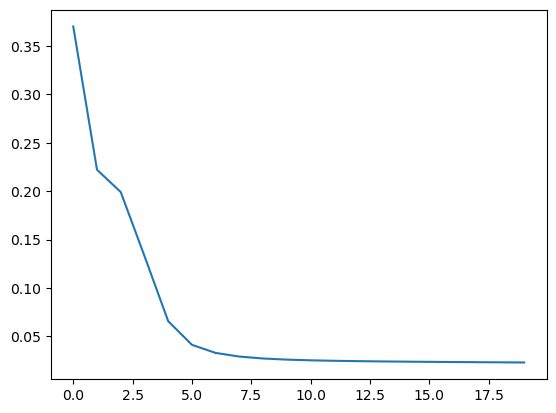

In [10]:
# Neural network definition
first_input_size = 2
neurons_per_layer = [8,4,1]
act_f_per_layer = [hyp_tans, hyp_tans, hyp_tans]

# Neural network creation
nn = neural_network(first_input_size, neurons_per_layer, act_f_per_layer)

# Training params
lr = 0.001
iterations = 1000

show_training(nn, X, Y, costs, lr, iterations)

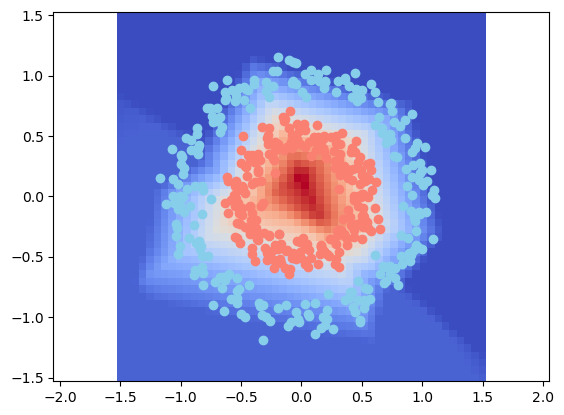

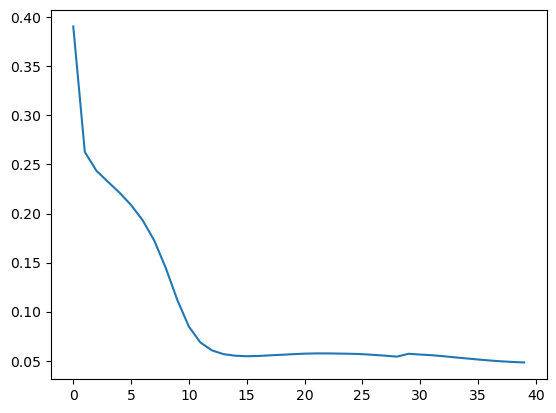

In [14]:
# Neural network definition
first_input_size = 2
neurons_per_layer = [8,4,1]
act_f_per_layer = [relus, relus, relus]

# Neural network creation
nn = neural_network(first_input_size, neurons_per_layer, act_f_per_layer)

# Training params
lr = 0.0005
iterations = 2000

show_training(nn, X, Y, costs, lr, iterations)